<a href="https://colab.research.google.com/github/lagonee23/price-prediction-models/blob/main/bitcoin_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 암호화폐(BitCoin)의 가격 예측 모델


### 필요 모듈 설치
> [pyupbit](https://github.com/sharebook-kr/pyupbit) 모듈은 업비트라는 암호화폐 거래소의 API를 파이썬에서 쉽게 사용하기 위해 개발되었습니다.
해당 라이브러리를 통해 암호화폐의 현재 가격, 매매 주문 등의 정보를 쉽게 얻어올 수 있습니다.

In [ ]:
!pip install pyupbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 2.8 MB/s eta 0:00:00


### 업비트에서 일봉(day)차트의 데이터 가져오기
* `open`: 시가
* `high`: 고가
* `low`: 저가
* `close`: 종가
* `volume`: 거래량
* `value`: 거래대금

> 업비트는 한국 거래소이므로 데이터의 단위는 원화(￦)입니다.

In [ ]:
import pyupbit

# UpBit에서 비트코인 가격 데이터 가져오기
df_origin = pyupbit.get_ohlcv("KRW-BTC", "day", count=2500, period=1)
df_origin

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2023-12-08 09:00:00,59237000.0,60753000.0,58750000.0,60142000.0,5252.133202,3.128890e+11
2023-12-09 09:00:00,60148000.0,60395000.0,59680000.0,60082000.0,3528.907593,2.121763e+11
2023-12-10 09:00:00,60082000.0,60277000.0,59563000.0,59835000.0,2575.294711,1.545037e+11
2023-12-11 09:00:00,59834000.0,59918000.0,55460000.0,56950000.0,11981.700488,6.909212e+11


In [ ]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2270 entries, 2017-09-25 09:00:00 to 2023-12-12 09:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2270 non-null   float64
 1   high    2270 non-null   float64
 2   low     2270 non-null   float64
 3   close   2270 non-null   float64
 4   volume  2270 non-null   float64
 5   value   2270 non-null   float64
dtypes: float64(6)
memory usage: 124.1 KB


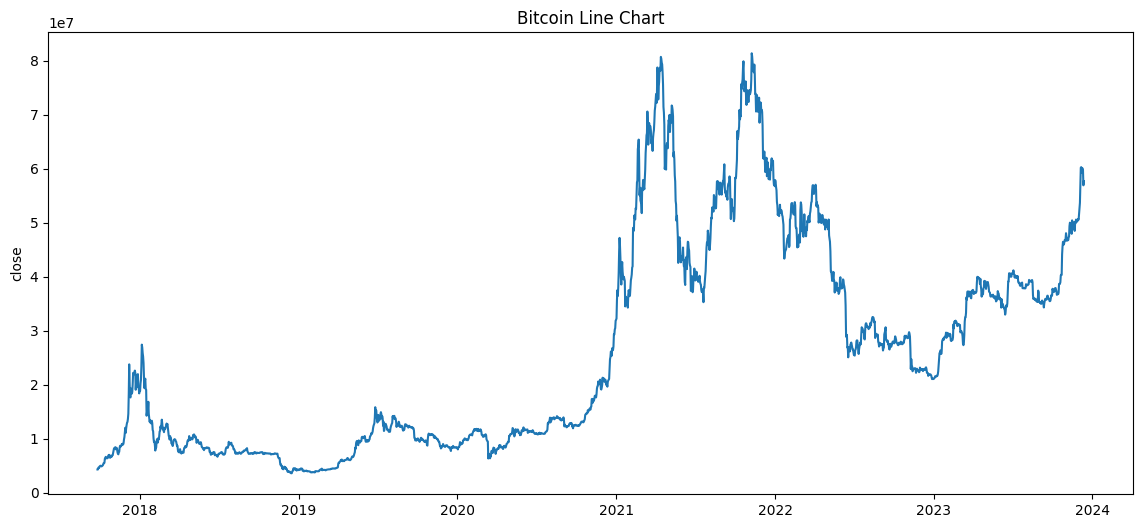

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_origin, x=df_origin.index, y='close')  # 비트코인 차트
plt.title('Bitcoin Line Chart');

## LSTM(Long Short Term Memory)
---
본 프로젝트에서는 long memory 특성을 보이는 비트코인의 가격 예측을 위한 딥러닝 모형으로 LSTM을 선택하였습니다. LSTM 모형을 이용하여 비트코인의 가격을 예측하고, 예측된 비트코인 가격을 이용한 이동평균선 교차 전략의 투자 성과를 비교 분석하겠습니다.

> [LSTM(Long Short-Term Memory)](https://wikidocs.net/152773) 모델은 순환 신경망(Recurrent Neural Network, RNN)의 한 종류로서, 시퀀스 데이터를 처리하는 데 효과적입니다. LSTM은 RNN의 장기 의존성 문제를 해결하기 위해 고안되었습니다.

### 1. 데이터 전처리
일별 수익률(`Return`) 컬럼을 추가합니다.

In [ ]:
# 원본 복사
df = df_origin.copy()

df['Return'] = df['close'].pct_change()
df.head()

,open,high,low,close,volume,value,Return
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08,NaN
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07,-0.000231
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08,0.077760
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08,-0.015246
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08,0.015482


In [ ]:
# 결측치 확인
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
value     0
Return    1
dtype: int64

In [ ]:
# 결측치 제거
df.dropna(inplace=True)
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
value     0
Return    0
dtype: int64

입력변수로는 비트코인의 일별 시가(`open`), 고가(`high`), 저가(`low`), 종가(`close`)와 일별 수익률(`Return`) 자료를 이용합니다. 5개의 입력변수를 이용하여 다음 날의 비트코인 종가를 예측하는 것을 목표로 합니다.

In [ ]:
input_data = df[['open', 'high', 'low', 'close', 'Return']].values

print("Input data shape:", input_data.shape, end="\n\n")
input_data

Input data shape: (2269, 5)



array([[ 4.31700000e+06,  4.41800000e+06,  4.31100000e+06,
         4.32100000e+06, -2.31374364e-04],
       [ 4.32200000e+06,  4.67700000e+06,  4.31800000e+06,
         4.65700000e+06,  7.77597778e-02],
       [ 4.65700000e+06,  4.77200000e+06,  4.51900000e+06,
         4.58600000e+06, -1.52458664e-02],
       ...,
       [ 6.00820000e+07,  6.02770000e+07,  5.95630000e+07,
         5.98350000e+07, -4.11104823e-03],
       [ 5.98340000e+07,  5.99180000e+07,  5.54600000e+07,
         5.69500000e+07, -4.82159271e-02],
       [ 5.69500000e+07,  5.87800000e+07,  5.66980000e+07,
         5.77020000e+07,  1.32045654e-02]])

* 연속된 5일의 데이터를 하나의 **시퀀스**로 설정합니다.
* 학습 데이터는 전체 데이터의 70%로 합니다.

In [ ]:
import math

sequence_length = 5

train_len = math.ceil(len(input_data) * 0.7)
train = input_data[0:train_len, :]
test = input_data[train_len - sequence_length:, :]

print("input data shape:", input_data.shape)
print("Train data shape:", train.shape)
print("Test data shape:", test.shape)

input data shape: (2269, 5)
Train data shape: (1589, 5)
Test data shape: (685, 5)


`MinMaxScaler()`는 최소/최대값이 각각 0, 1이 되도록 하여스 모든 feature 값이 0~1 사이에 있도록 데이터를 재조정합니다.

$$ Y = \frac{X-X_{min}}{X_{max}-X_{min}} $$



In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train = scaler.fit_transform(train)  # 학습 데이터 스케일링
test = scaler.transform(test)  # 테스트 데이터 스케일링

print("Train data shape:", train.shape)
print("Test data shape:", test.shape, end="\n\n")
train

Train data shape: (1589, 5)
Test data shape: (685, 5)



array([[0.00896094, 0.00927672, 0.00980046, 0.00902499, 0.52942638],
       [0.00902522, 0.01255458, 0.00989205, 0.01334465, 0.65429073],
       [0.01333213, 0.01375688, 0.01252208, 0.01243186, 0.50538808],
       ...,
       [0.55246715, 0.5576283 , 0.55764475, 0.55958809, 0.54897261],
       [0.55956391, 0.55451497, 0.56180569, 0.56038517, 0.53190224],
       [0.56038672, 0.55637537, 0.55036964, 0.56113082, 0.53176382]])

학습 데이터, 테스트 데이터의 **특성(features)** 및 **타겟(target)** 변수를 정의합니다.

In [ ]:
import numpy as np

# 학습 데이터
X_train, y_train = [], []

for i in range(sequence_length, len(train)):
    X_train.append(train[i-sequence_length:i, :])
    y_train.append(train[i, 3])

X_train, y_train = np.array(X_train), np.array(y_train)


# 테스트 데이터
X_test = []
y_test = df['close'][train_len:].values

for i in range(sequence_length, len(test)):
    X_test.append(test[i-sequence_length:i, :])

X_test = np.array(X_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", y_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1584, 5, 5)
y_train shape: (1584,)
X_test shape: (680,)
y_test shape: (680,)


### 2. Modeling

In [ ]:
import tensorflow as tf

# 하이퍼 파라미터(Hyperparameter)를 설정하여 모델을 정의합니다.
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 5)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1),
])

# 모델 컴파일
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             11200     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32701 (127.74 KB)
Trainable params: 32701 (127.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 학습
unicorns = model.fit(X_train, y_train, batch_size=10, epochs=5)

# 예측
# pred = model.predict(X_test)
# pred = scaler.inverse_transform(pred)

# # 성능 평가
# rmse = math.sqrt(mean_squared_error(y_test, predictions))
# print('RMSE: ', rmse)

Epoch 1/5
159/159 [==============================] - 3s 6ms/step - loss: 3.2441e-04 - accuracy: 0.0013
Epoch 2/5
159/159 [==============================] - 1s 6ms/step - loss: 2.8948e-04 - accuracy: 0.0013
Epoch 3/5
159/159 [==============================] - 1s 6ms/step - loss: 2.9568e-04 - accuracy: 0.0013
Epoch 4/5
159/159 [==============================] - 1s 9ms/step - loss: 2.9809e-04 - accuracy: 0.0013
Epoch 5/5
159/159 [==============================] - 1s 9ms/step - loss: 3.0710e-04 - accuracy: 0.0013


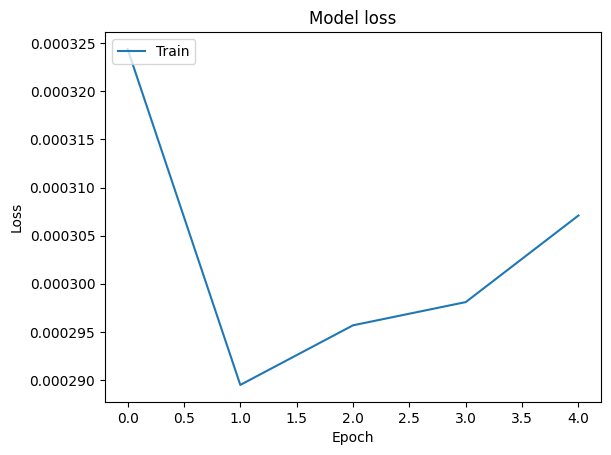

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
# plt.plot(unicorns.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

### 평가지표

In [ ]:
from sklearn.metrics import classification_report

y_pred_test_log = logCV_model.predict(X_test_std)

print(classification_report(y_test, y_pred_test_log))

NameError: ignored